# Imports

In [0]:
import numpy as np
from scipy import ndimage
import matplotlib.pylab as pl
from google.colab import files, drive
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model, load_model
from keras import backend as K
from sklearn.metrics import mean_squared_error
import math


In [0]:
drive.mount('/content/drive/')
path = "drive/My Drive/computer_vision/"

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# **Load matrices and plot images**

In [0]:
# load matrices
xtrain = np.load(path+'x_train.npy')
xval = np.load(path+'x_val.npy')
ytrain = np.load(path+'y_train.npy')
yval = np.load(path+'y_val.npy')

Text(0.5, 1.0, 'Cow 2')

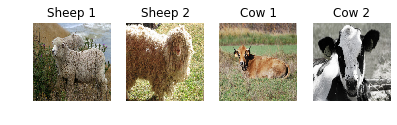

In [0]:
# plot 2 "good" images of each class
pl.figure(1, figsize=(6.4, 3))

pl.subplot(1, 4, 1)
pl.imshow(xtrain[3])
pl.axis('off')
pl.title('Sheep 1')

pl.subplot(1, 4, 2)
pl.imshow(xtrain[1])
pl.axis('off')
pl.title('Sheep 2')

pl.subplot(1, 4, 3)
pl.imshow(xtrain[-1])
pl.axis('off')
pl.title('Cow 1')

pl.subplot(1, 4, 4)
pl.imshow(xtrain[-2])
pl.axis('off')
pl.title('Cow 2')

In [0]:
# plot whole training set
pl.figure(1, figsize=(20, 40))
for i in range(len(xtrain)):
    pl.subplot(16, 10, i+1)
    pl.imshow(xtrain[i])
    pl.axis('off')
    pl.title(str(i))



In [0]:
# plot whole validation set
pl.figure(1, figsize=(20, 40))
for i in range(len(xval)):
    pl.subplot(15, 10, i+1)
    pl.imshow(xval[i])
    pl.axis('off')
    pl.title(str(i))

# **Auto-encoders**


## PCA vs Auto-encoders


PCA aim: find a few directions in the input space explaining the variation in the input data; project the data onto those dimentionss

--> linear relationship between the data and the learned representation

Here 2 PCs used (reduction from dimension 137388 to 2; of course bad, but to be able to plot)





AE: NN whose outputs are its own inputs; same objective function as PCA

Goal = minimize reconstruction error

inputs x --> lower dim z = f(Wx) --> reconstruction higher dim ~x = g(Vz)

goal --> min sum (x - ~x)^2 

         --> = min sum (x - VWx)^2        if f and g are linear
         
                      => optimal solution is PCA
                      
2 neurons in hidden layer --> approximate to reducing data to 2 features

With linear activation function and a single hidden layer of size p, the weights of the AE span the same vector subspace as the one spanned by the first p components of PCA, and the output of AE is an orthogonal projection onto this subspace

/!\ AE weights != PCs --> in general weights not orthogonal but the PCs can be recovered using Singular Value Decomposition (Plaut, E.,From Principal Subspaces to Principal Components with Linear Autoencoders, Arxiv.org:1804.10253.)

--> to compare PCA and AE, compare reconstruction error


Reconstruction error for PCA - small values as values between 0 and 1: 
- 2 PC -->PCA:  0.042292733 --------- LAE: 0.064802356
- 16 PCs --> 0.022215268 --------- LAE: 0.026056455
- 50 PCs --> 0.010987376 --------- LAE: 0.026697977
- all PCs --> 5.317535e-13 --------- LAE: 0.03401486


16 components explained variance ratio = 10^-2 or more other evr = 10^-3 or less 



From visual evaluation here PCA is better than linear AE
From reconstruction error comparison here PCA is better than linear AE



- the autoencoder is better at reconstructing the original data set than PCA when p is small (but the error converges as p increases) --> for very large data sets this difference will be larger --> means that same accuracy can be achieved with less components than for PCA and hence a smaller data set

- in PCA, we can choose the #PCs based on the % of variability they explain; with AE, we don't know how many to keep (can you PCA to determine how many neurons in hidden layer)


- better visualization possible with AE than with PCA



### PCA

In [0]:
# reshape: 153 x 256*256*3 = 153 x 196608
# if 128 --> 49152
xrs = xtrain.reshape(len(xtrain), len(xtrain[0])*len(xtrain[0,0])*len(xtrain[0,0,0]))
# scale (mean-center)
# scaler = StandardScaler()
# scaler.fit(xrs)
# xscaled = scaler.transform(xrs)
# centering done in decomposition.PCA method
# no need to scale as all same scale (all values represent a pixel)
# already between 0 and 1
xscaled = xrs
xvrs = xval.reshape(len(xval), len(xval[0])*len(xval[0,0])*len(xval[0,0,0]))
# use scaler fitted on xtrain because no assumptions about xval
# xvscaled = scaler.transform(xvrs)
xvscaled = xvrs

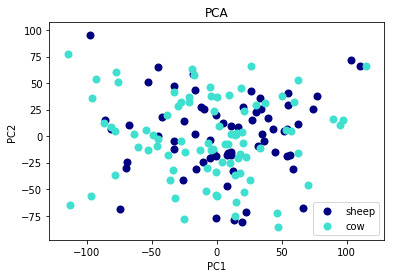

In [0]:
# PCA
pca = PCA()
pca_transformed = pca.fit_transform(xscaled)

# Get first 2 PCs
pca_2pcs = pca_transformed[:,:2]

# Plot 2 PCs of PCA
plt.figure()
lw = 2
for i in range(67):
  if i==0:
    plt.scatter(pca_2pcs[i, 0], pca_2pcs[i, 1], color='navy', alpha=1., lw=lw,
                label='sheep')
  else: # otherwise one point per sample in legend
    plt.scatter(pca_2pcs[i, 0], pca_2pcs[i, 1], color='navy', alpha=1., lw=lw)
    
for i in range(86):
  if i==0:
    plt.scatter(pca_2pcs[67+i, 0], pca_2pcs[67+i, 1], color='turquoise', alpha=1.,
                lw=lw, label='cow')
  else:
    plt.scatter(pca_2pcs[67+i, 0], pca_2pcs[67+i, 1], color='turquoise', alpha=1.,
                lw=lw)
   
    
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA')  
plt.xlabel('PC' + "1")
plt.ylabel('PC' + "2")
plt.show()


Text(0, 0.5, 'Cumulative explained variance')

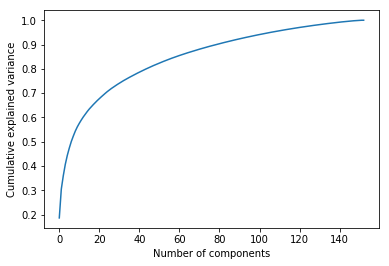

In [0]:
#print(pca.explained_variance_ratio_) 

# not fast and big increase in cumsum --> var distributed over a lot of components
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

### PCA reconstructions with diff #PCs

0.042292733


Text(0.5, 1.0, 'Cow 2')

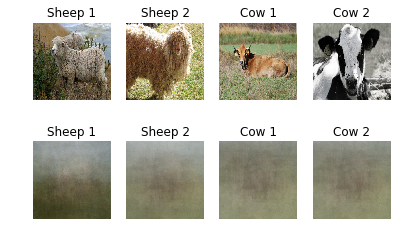

In [0]:
# Reconstruction with 2 components
pca = PCA(n_components=2)
pca_transformed = pca.fit_transform(xscaled)
inv_pca = pca.inverse_transform(pca_transformed)
inv_xtrain = inv_pca.reshape(len(xtrain), len(xtrain[0]), len(xtrain[0,0]), len(xtrain[0,0,0]))

print(mean_squared_error(xrs,inv_pca))


# plot 2 "good" images of each class
pl.figure(1, figsize=(6.4, 4))

pl.subplot(2, 4, 1)
pl.imshow(xtrain[3])
pl.axis('off')
pl.title('Sheep 1')

pl.subplot(2, 4, 2)
pl.imshow(xtrain[1])
pl.axis('off')
pl.title('Sheep 2')

pl.subplot(2, 4, 3)
pl.imshow(xtrain[-1])
pl.axis('off')
pl.title('Cow 1')

pl.subplot(2, 4, 4)
pl.imshow(xtrain[-2])
pl.axis('off')
pl.title('Cow 2')

pl.subplot(2, 4, 5)
pl.imshow(inv_xtrain[3])
pl.axis('off')
pl.title('Sheep 1')

pl.subplot(2, 4, 6)
pl.imshow(inv_xtrain[1])
pl.axis('off')
pl.title('Sheep 2')

pl.subplot(2, 4, 7)
pl.imshow(inv_xtrain[-1])
pl.axis('off')
pl.title('Cow 1')

pl.subplot(2, 4, 8)
pl.imshow(inv_xtrain[-2])
pl.axis('off')
pl.title('Cow 2')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.022214076


Text(0.5, 1.0, 'Cow 2')

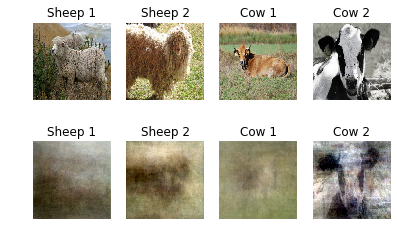

In [0]:
# Reconstruction with 16 components
pca = PCA(n_components=16)
pca_transformed = pca.fit_transform(xscaled)
inv_pca = pca.inverse_transform(pca_transformed)
inv_xtrain = inv_pca.reshape(len(xtrain), len(xtrain[0]), len(xtrain[0,0]), len(xtrain[0,0,0]))

print(mean_squared_error(xrs,inv_pca))


# plot 2 "good" images of each class
pl.figure(1, figsize=(6.4, 4))

pl.subplot(2, 4, 1)
pl.imshow(xtrain[3])
pl.axis('off')
pl.title('Sheep 1')

pl.subplot(2, 4, 2)
pl.imshow(xtrain[1])
pl.axis('off')
pl.title('Sheep 2')

pl.subplot(2, 4, 3)
pl.imshow(xtrain[-1])
pl.axis('off')
pl.title('Cow 1')

pl.subplot(2, 4, 4)
pl.imshow(xtrain[-2])
pl.axis('off')
pl.title('Cow 2')

pl.subplot(2, 4, 5)
pl.imshow(inv_xtrain[3])
pl.axis('off')
pl.title('Sheep 1')

pl.subplot(2, 4, 6)
pl.imshow(inv_xtrain[1])
pl.axis('off')
pl.title('Sheep 2')

pl.subplot(2, 4, 7)
pl.imshow(inv_xtrain[-1])
pl.axis('off')
pl.title('Cow 1')

pl.subplot(2, 4, 8)
pl.imshow(inv_xtrain[-2])
pl.axis('off')
pl.title('Cow 2')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.011008691


Text(0.5, 1.0, 'Cow 2')

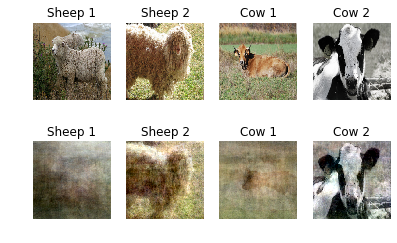

In [0]:
# Reconstruction with 50 components
pca = PCA(n_components=50)
pca_transformed = pca.fit_transform(xscaled)
inv_pca = pca.inverse_transform(pca_transformed)
inv_xtrain = inv_pca.reshape(len(xtrain), len(xtrain[0]), len(xtrain[0,0]), len(xtrain[0,0,0]))

print(mean_squared_error(xrs,inv_pca))


# plot 2 "good" images of each class
pl.figure(1, figsize=(6.4, 4))

pl.subplot(2, 4, 1)
pl.imshow(xtrain[3])
pl.axis('off')
pl.title('Sheep 1')

pl.subplot(2, 4, 2)
pl.imshow(xtrain[1])
pl.axis('off')
pl.title('Sheep 2')

pl.subplot(2, 4, 3)
pl.imshow(xtrain[-1])
pl.axis('off')
pl.title('Cow 1')

pl.subplot(2, 4, 4)
pl.imshow(xtrain[-2])
pl.axis('off')
pl.title('Cow 2')

pl.subplot(2, 4, 5)
pl.imshow(inv_xtrain[3])
pl.axis('off')
pl.title('Sheep 1')

pl.subplot(2, 4, 6)
pl.imshow(inv_xtrain[1])
pl.axis('off')
pl.title('Sheep 2')

pl.subplot(2, 4, 7)
pl.imshow(inv_xtrain[-1])
pl.axis('off')
pl.title('Cow 1')

pl.subplot(2, 4, 8)
pl.imshow(inv_xtrain[-2])
pl.axis('off')
pl.title('Cow 2')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5.317535e-13


Text(0.5, 1.0, 'Cow 2')

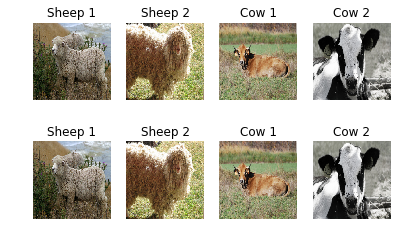

In [0]:
# Reconstruction with 153=all components
pca = PCA(n_components=153)
pca_transformed = pca.fit_transform(xscaled)
inv_pca = pca.inverse_transform(pca_transformed)
inv_xtrain = inv_pca.reshape(len(xtrain), len(xtrain[0]), len(xtrain[0,0]), len(xtrain[0,0,0]))

print(mean_squared_error(xrs,inv_pca))


# plot 2 "good" images of each class
pl.figure(1, figsize=(6.4, 4))

pl.subplot(2, 4, 1)
pl.imshow(xtrain[3])
pl.axis('off')
pl.title('Sheep 1')

pl.subplot(2, 4, 2)
pl.imshow(xtrain[1])
pl.axis('off')
pl.title('Sheep 2')

pl.subplot(2, 4, 3)
pl.imshow(xtrain[-1])
pl.axis('off')
pl.title('Cow 1')

pl.subplot(2, 4, 4)
pl.imshow(xtrain[-2])
pl.axis('off')
pl.title('Cow 2')

pl.subplot(2, 4, 5)
pl.imshow(inv_xtrain[3])
pl.axis('off')
pl.title('Sheep 1')

pl.subplot(2, 4, 6)
pl.imshow(inv_xtrain[1])
pl.axis('off')
pl.title('Sheep 2')

pl.subplot(2, 4, 7)
pl.imshow(inv_xtrain[-1])
pl.axis('off')
pl.title('Cow 1')

pl.subplot(2, 4, 8)
pl.imshow(inv_xtrain[-2])
pl.axis('off')
pl.title('Cow 2')

### AE

PCA with 2 PCs does not allow to separate the 2 classes
 (quite expected... drastic dimensionality reduction)
 
 --> variance quite spread over many components

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        (None, 196608)            0         
_________________________________________________________________
dense_19 (Dense)             (None, 2)                 393218    
_________________________________________________________________
dense_20 (Dense)             (None, 196608)            589824    
Total params: 983,042
Trainable params: 983,042
Non-trainable params: 0
_________________________________________________________________
None


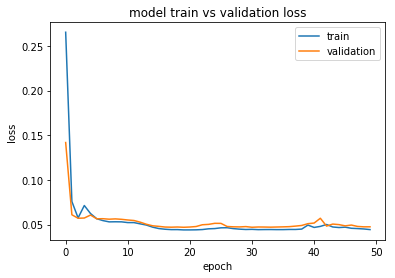

In [0]:
# Create an AE and fit it with the data using 2 neurons in the hidden layer (to compare with 2 PCs)
# --> fully-connected
# --> use linear activation function
input_dim = xscaled.shape[1] # size*size*3
encoding_dim = 2  
input_img = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='linear')(input_img)
decoded = Dense(input_dim, activation='linear')(encoded)
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')
print(autoencoder.summary())

history = autoencoder.fit(xscaled, xscaled,
                epochs=50,
                batch_size=16,
                shuffle=True,
                validation_data=(xvscaled, xvscaled),
                         verbose=0)

# Plot the loss --> MSE
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

# Use the encoded layer to encode the training input
encoder = Model(input_img, encoded)
encoded_input = Input(shape=(encoding_dim,))
decoder_layer = autoencoder.layers[-1]
decoder = Model(encoded_input, decoder_layer(encoded_input))
encoded_data = encoder.predict(xscaled)

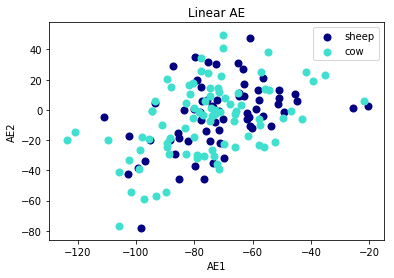

In [0]:
# Get first 2 features --> weight vectors
ae_weights = encoded_data[:,:2] # normally already shape (153, 2) with 2 neurons

# Plot the 2 weight vectors of AE
plt.figure()
lw = 2
for i in range(67):
  if i==0:
    plt.scatter(ae_weights[i, 0], ae_weights[i, 1], color='navy', alpha=1., lw=lw,
                label='sheep')
  else: # otherwise one point per sample in legend
    plt.scatter(ae_weights[i, 0], ae_weights[i, 1], color='navy', alpha=1., lw=lw)
    
for i in range(86):
  if i==0:
    plt.scatter(ae_weights[67+i, 0], ae_weights[67+i, 1], color='turquoise', alpha=1.,
                lw=lw, label='cow')
  else:
    plt.scatter(ae_weights[67+i, 0], ae_weights[67+i, 1], color='turquoise', alpha=1.,
                lw=lw)
   
    
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('Linear AE')  
plt.xlabel('AE' + "1")
plt.ylabel('AE' + "2")
plt.show()

Linear AE very similar to PCA

### Reconstruction AE diff #neurons

0.043992877


Text(0.5, 1.0, 'Cow 2')

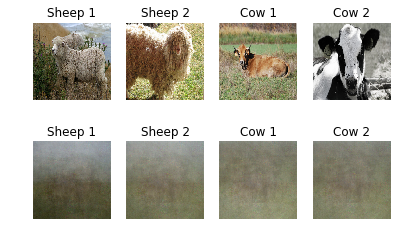

In [0]:
decoded_data = autoencoder.predict(xscaled)
decoded_imgs = decoded_data.reshape(len(xtrain), len(xtrain[0]), len(xtrain[0,0]), len(xtrain[0,0,0]))

print(mean_squared_error(xrs,decoded_data))

# plot 2 "good" images of each class
pl.figure(1, figsize=(6.4, 4))

pl.subplot(2, 4, 1)
pl.imshow(xtrain[3])
pl.axis('off')
pl.title('Sheep 1')

pl.subplot(2, 4, 2)
pl.imshow(xtrain[1])
pl.axis('off')
pl.title('Sheep 2')

pl.subplot(2, 4, 3)
pl.imshow(xtrain[-1])
pl.axis('off')
pl.title('Cow 1')

pl.subplot(2, 4, 4)
pl.imshow(xtrain[-2])
pl.axis('off')
pl.title('Cow 2')

pl.subplot(2, 4, 5)
pl.imshow(decoded_imgs[3])
pl.axis('off')
pl.title('Sheep 1')

pl.subplot(2, 4, 6)
pl.imshow(decoded_imgs[1])
pl.axis('off')
pl.title('Sheep 2')

pl.subplot(2, 4, 7)
pl.imshow(decoded_imgs[-1])
pl.axis('off')
pl.title('Cow 1')

pl.subplot(2, 4, 8)
pl.imshow(decoded_imgs[-2])
pl.axis('off')
pl.title('Cow 2')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        (None, 196608)            0         
_________________________________________________________________
dense_21 (Dense)             (None, 16)                3145744   
_________________________________________________________________
dense_22 (Dense)             (None, 196608)            3342336   
Total params: 6,488,080
Trainable params: 6,488,080
Non-trainable params: 0
_________________________________________________________________
None


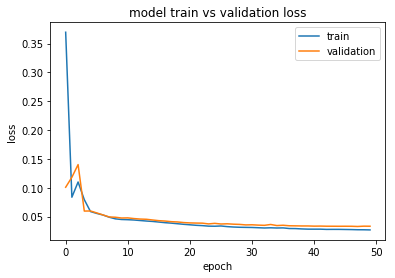

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.026487203


Text(0.5, 1.0, 'Cow 2')

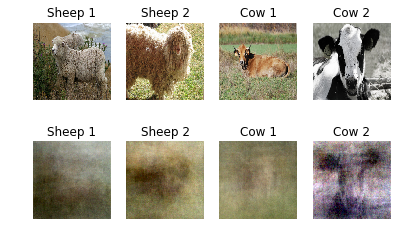

In [0]:
# Create an AE and fit it with the data using 16 neurons in the hidden layer (to compare with 16 PCs)
# --> fully-connected
# --> use linear activation function
input_dim = xscaled.shape[1] # size*size*3
encoding_dim = 16  
input_img = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='linear')(input_img)
decoded = Dense(input_dim, activation='linear')(encoded)
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')
print(autoencoder.summary())

history = autoencoder.fit(xscaled, xscaled,
                epochs=50,
                batch_size=16,
                shuffle=True,
                validation_data=(xvscaled, xvscaled),
                verbose = 0)

# Plot the loss --> MSE
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

# Use the encoded layer to encode the training input
encoder = Model(input_img, encoded)
encoded_input = Input(shape=(encoding_dim,))
decoder_layer = autoencoder.layers[-1]
decoder = Model(encoded_input, decoder_layer(encoded_input))
encoded_data = encoder.predict(xscaled)

decoded_data = autoencoder.predict(xscaled)
decoded_imgs = decoded_data.reshape(len(xtrain), len(xtrain[0]), len(xtrain[0,0]), len(xtrain[0,0,0]))

print(mean_squared_error(xrs,decoded_data))

# plot 2 "good" images of each class
pl.figure(1, figsize=(6.4, 4))

pl.subplot(2, 4, 1)
pl.imshow(xtrain[3])
pl.axis('off')
pl.title('Sheep 1')

pl.subplot(2, 4, 2)
pl.imshow(xtrain[1])
pl.axis('off')
pl.title('Sheep 2')

pl.subplot(2, 4, 3)
pl.imshow(xtrain[-1])
pl.axis('off')
pl.title('Cow 1')

pl.subplot(2, 4, 4)
pl.imshow(xtrain[-2])
pl.axis('off')
pl.title('Cow 2')

pl.subplot(2, 4, 5)
pl.imshow(decoded_imgs[3])
pl.axis('off')
pl.title('Sheep 1')

pl.subplot(2, 4, 6)
pl.imshow(decoded_imgs[1])
pl.axis('off')
pl.title('Sheep 2')

pl.subplot(2, 4, 7)
pl.imshow(decoded_imgs[-1])
pl.axis('off')
pl.title('Cow 1')

pl.subplot(2, 4, 8)
pl.imshow(decoded_imgs[-2])
pl.axis('off')
pl.title('Cow 2')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_24 (InputLayer)        (None, 196608)            0         
_________________________________________________________________
dense_23 (Dense)             (None, 50)                9830450   
_________________________________________________________________
dense_24 (Dense)             (None, 196608)            10027008  
Total params: 19,857,458
Trainable params: 19,857,458
Non-trainable params: 0
_________________________________________________________________
None


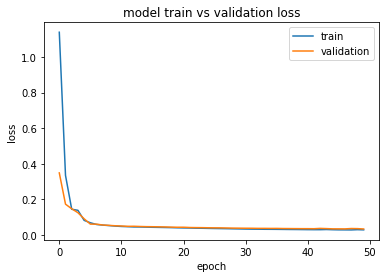

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.026791723


Text(0.5, 1.0, 'Cow 2')

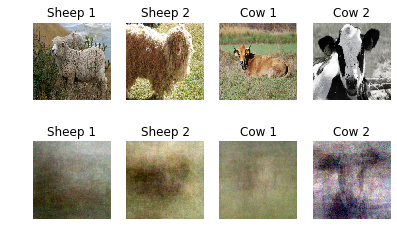

In [0]:
# Create an AE and fit it with the data using 50 neurons in the hidden layer (to compare with 50 PCs)
# --> fully-connected
# --> use linear activation function
input_dim = xscaled.shape[1] # size*size*3
encoding_dim = 50  
input_img = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='linear')(input_img)
decoded = Dense(input_dim, activation='linear')(encoded)
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')
print(autoencoder.summary())

history = autoencoder.fit(xscaled, xscaled,
                epochs=50,
                batch_size=16,
                shuffle=True,
                validation_data=(xvscaled, xvscaled),
                verbose = 0)

# Plot the loss --> MSE
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

# Use the encoded layer to encode the training input
encoder = Model(input_img, encoded)
encoded_input = Input(shape=(encoding_dim,))
decoder_layer = autoencoder.layers[-1]
decoder = Model(encoded_input, decoder_layer(encoded_input))
encoded_data = encoder.predict(xscaled)

decoded_data = autoencoder.predict(xscaled)
decoded_imgs = decoded_data.reshape(len(xtrain), len(xtrain[0]), len(xtrain[0,0]), len(xtrain[0,0,0]))

print(mean_squared_error(xrs,decoded_data))

# plot 2 "good" images of each class
pl.figure(1, figsize=(6.4, 4))

pl.subplot(2, 4, 1)
pl.imshow(xtrain[3])
pl.axis('off')
pl.title('Sheep 1')

pl.subplot(2, 4, 2)
pl.imshow(xtrain[1])
pl.axis('off')
pl.title('Sheep 2')

pl.subplot(2, 4, 3)
pl.imshow(xtrain[-1])
pl.axis('off')
pl.title('Cow 1')

pl.subplot(2, 4, 4)
pl.imshow(xtrain[-2])
pl.axis('off')
pl.title('Cow 2')

pl.subplot(2, 4, 5)
pl.imshow(decoded_imgs[3])
pl.axis('off')
pl.title('Sheep 1')

pl.subplot(2, 4, 6)
pl.imshow(decoded_imgs[1])
pl.axis('off')
pl.title('Sheep 2')

pl.subplot(2, 4, 7)
pl.imshow(decoded_imgs[-1])
pl.axis('off')
pl.title('Cow 1')

pl.subplot(2, 4, 8)
pl.imshow(decoded_imgs[-2])
pl.axis('off')
pl.title('Cow 2')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_26 (InputLayer)        (None, 196608)            0         
_________________________________________________________________
dense_25 (Dense)             (None, 153)               30081177  
_________________________________________________________________
dense_26 (Dense)             (None, 196608)            30277632  
Total params: 60,358,809
Trainable params: 60,358,809
Non-trainable params: 0
_________________________________________________________________
None


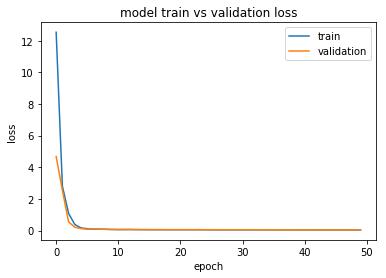

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.036522422


Text(0.5, 1.0, 'Cow 2')

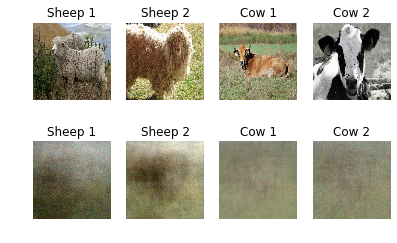

In [0]:
# Create an AE and fit it with the data using 153 neurons in the hidden layer (to compare with 153 PCs)
# --> fully-connected
# --> use linear activation function
input_dim = xscaled.shape[1] # size*size*3
encoding_dim = 153  
input_img = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='linear')(input_img)
decoded = Dense(input_dim, activation='linear')(encoded)
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')
print(autoencoder.summary())

history = autoencoder.fit(xscaled, xscaled,
                epochs=50,
                batch_size=16,
                shuffle=True,
                validation_data=(xvscaled, xvscaled),
                verbose = 0)

# Plot the loss --> MSE
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

# Use the encoded layer to encode the training input
encoder = Model(input_img, encoded)
encoded_input = Input(shape=(encoding_dim,))
decoder_layer = autoencoder.layers[-1]
decoder = Model(encoded_input, decoder_layer(encoded_input))
encoded_data = encoder.predict(xscaled)

decoded_data = autoencoder.predict(xscaled)
decoded_imgs = decoded_data.reshape(len(xtrain), len(xtrain[0]), len(xtrain[0,0]), len(xtrain[0,0,0]))

print(mean_squared_error(xrs,decoded_data))

# plot 2 "good" images of each class
pl.figure(1, figsize=(6.4, 4))

pl.subplot(2, 4, 1)
pl.imshow(xtrain[3])
pl.axis('off')
pl.title('Sheep 1')

pl.subplot(2, 4, 2)
pl.imshow(xtrain[1])
pl.axis('off')
pl.title('Sheep 2')

pl.subplot(2, 4, 3)
pl.imshow(xtrain[-1])
pl.axis('off')
pl.title('Cow 1')

pl.subplot(2, 4, 4)
pl.imshow(xtrain[-2])
pl.axis('off')
pl.title('Cow 2')

pl.subplot(2, 4, 5)
pl.imshow(decoded_imgs[3])
pl.axis('off')
pl.title('Sheep 1')

pl.subplot(2, 4, 6)
pl.imshow(decoded_imgs[1])
pl.axis('off')
pl.title('Sheep 2')

pl.subplot(2, 4, 7)
pl.imshow(decoded_imgs[-1])
pl.axis('off')
pl.title('Cow 1')

pl.subplot(2, 4, 8)
pl.imshow(decoded_imgs[-2])
pl.axis('off')
pl.title('Cow 2')

## Non-linear and convolutional AE

### AE1

In [0]:
# AE1
# size code --> /4

input_img = Input(shape=(len(xtrain[0]),len(xtrain[0,0]),len(xtrain[0,0,0]))) 
# 196608 dimensions if 256
# 49152 if 128

net = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
net = MaxPooling2D((2, 2), padding='same')(net)
net = Conv2D(8, (3, 3), activation='relu', padding='same')(net)
encoded = MaxPooling2D((2, 2), padding='same')(net)

# "code" layer: at this point the representation is 
  # (32, 32, 8) --> 8192 dimensions if 256
  # (16, 16, 8) --> 2018 if 128

net = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
net = UpSampling2D((2, 2))(net)
net = Conv2D(16, (3, 3), activation='relu', padding='same')(net)
net = UpSampling2D((2, 2))(net)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(net)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')
print(autoencoder.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_31 (InputLayer)        (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 256, 256, 16)      448       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 128, 128, 8)       1160      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 64, 64, 8)         0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 64, 64, 8)         584       
_________________________________________________________________
up_sampling2d_12 (UpSampling (None, 128, 128, 8)       0         
__________

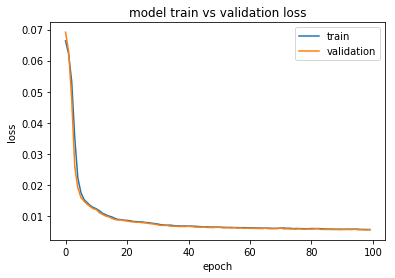

In [0]:
history = autoencoder.fit(xtrain, xtrain,
                epochs=100,
                batch_size=16,
                shuffle=True,
                validation_data=(xval, xval),
                         verbose=0)

# Plot the loss --> (binary cross-entropy) MSE
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

0.005691339


Text(0.5, 1.0, 'Cow 2')

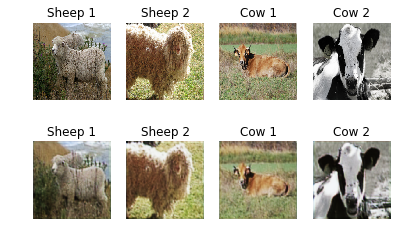

In [0]:
decoded_imgs = autoencoder.predict(xtrain)
decoded_rs = decoded_imgs.reshape(len(xtrain), len(xtrain[0])*len(xtrain[0,0])*len(xtrain[0,0,0]))

print(mean_squared_error(xrs,decoded_rs))

# plot 2 "good" images of each class
pl.figure(1, figsize=(6.4, 4))

pl.subplot(2, 4, 1)
pl.imshow(xtrain[3])
pl.axis('off')
pl.title('Sheep 1')

pl.subplot(2, 4, 2)
pl.imshow(xtrain[1])
pl.axis('off')
pl.title('Sheep 2')

pl.subplot(2, 4, 3)
pl.imshow(xtrain[-1])
pl.axis('off')
pl.title('Cow 1')

pl.subplot(2, 4, 4)
pl.imshow(xtrain[-2])
pl.axis('off')
pl.title('Cow 2')

pl.subplot(2, 4, 5)
pl.imshow(decoded_imgs[3])
pl.axis('off')
pl.title('Sheep 1')

pl.subplot(2, 4, 6)
pl.imshow(decoded_imgs[1])
pl.axis('off')
pl.title('Sheep 2')

pl.subplot(2, 4, 7)
pl.imshow(decoded_imgs[-1])
pl.axis('off')
pl.title('Cow 1')

pl.subplot(2, 4, 8)
pl.imshow(decoded_imgs[-2])
pl.axis('off')
pl.title('Cow 2')

Text(0.5, 1.0, 'Cow 2')

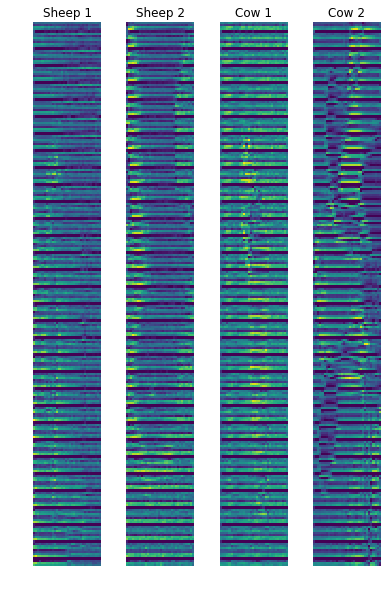

In [0]:
# Show encoded representations
encoder = Model(input_img, encoded)
encoded_imgs = encoder.predict(xtrain)
pl.figure(1, figsize=(6.4, 10))

s = int(len(xtrain[0])/4)

pl.subplot(1, 4, 1)
pl.imshow(encoded_imgs[3].reshape(s, s * 8).T)
pl.axis('off')
pl.title('Sheep 1')

pl.subplot(1, 4, 2)
pl.imshow(encoded_imgs[1].reshape(s, s * 8).T)
pl.axis('off')
pl.title('Sheep 2')

pl.subplot(1, 4, 3)
pl.imshow(encoded_imgs[-1].reshape(s, s * 8).T)
pl.axis('off')
pl.title('Cow 1')

pl.subplot(1, 4, 4)
pl.imshow(encoded_imgs[-2].reshape(s, s * 8).T)
pl.axis('off')
pl.title('Cow 2')

### AE2

In [0]:
# AE2
# size code --> /8

from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K

input_img = Input(shape=(len(xtrain[0]),len(xtrain[0,0]),len(xtrain[0,0,0]))) 
# 196608 dimensions if 256
# 49152 if 128

net = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
net = MaxPooling2D((2, 2), padding='same')(net)
net = Conv2D(8, (3, 3), activation='relu', padding='same')(net)
net = MaxPooling2D((2, 2), padding='same')(net)
net = Conv2D(8, (3, 3), activation='relu', padding='same')(net)
encoded = MaxPooling2D((2, 2), padding='same')(net)

# "code" layer: at this point the representation is 
  # (32, 32, 8) --> 8192 dimensions if 256
  # (16, 16, 8) --> 2018 if 128

net = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
net = UpSampling2D((2, 2))(net)
net = Conv2D(8, (3, 3), activation='relu', padding='same')(net)
net = UpSampling2D((2, 2))(net)
net = Conv2D(16, (3, 3), activation='relu', padding='same')(net)
net = UpSampling2D((2, 2))(net)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(net)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')
print(autoencoder.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_32 (InputLayer)        (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 256, 256, 16)      448       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 128, 128, 8)       1160      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 64, 64, 8)         0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 64, 64, 8)         584       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 32, 32, 8)         0         
__________

Train on 153 samples, validate on 150 samples
Epoch 1/100
153/153 [==============================] - 2s 13ms/step - loss: 0.0671 - val_loss: 0.0714
Epoch 2/100
153/153 [==============================] - 1s 4ms/step - loss: 0.0648 - val_loss: 0.0671
Epoch 3/100
153/153 [==============================] - 1s 4ms/step - loss: 0.0576 - val_loss: 0.0554
Epoch 4/100
153/153 [==============================] - 1s 4ms/step - loss: 0.0465 - val_loss: 0.0446
Epoch 5/100
153/153 [==============================] - 1s 4ms/step - loss: 0.0410 - val_loss: 0.0427
Epoch 6/100
153/153 [==============================] - 1s 4ms/step - loss: 0.0385 - val_loss: 0.0387
Epoch 7/100
153/153 [==============================] - 1s 4ms/step - loss: 0.0365 - val_loss: 0.0373
Epoch 8/100
153/153 [==============================] - 1s 4ms/step - loss: 0.0351 - val_loss: 0.0358
Epoch 9/100
153/153 [==============================] - 1s 4ms/step - loss: 0.0338 - val_loss: 0.0345
Epoch 10/100
153/153 [======================

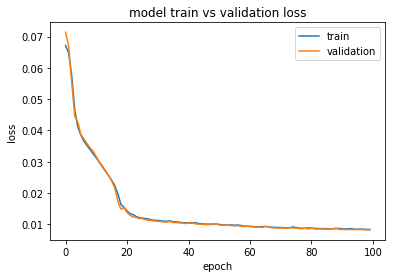

In [0]:
history = autoencoder.fit(xtrain, xtrain,
                epochs=100,
                batch_size=16,
                shuffle=True,
                validation_data=(xval, xval))

# Plot the loss --> (binary cross-entropy) MSE
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

0.008381459


Text(0.5, 1.0, 'Cow 2')

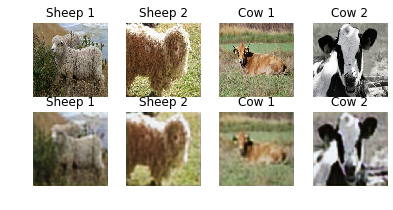

In [0]:
decoded_imgs = autoencoder.predict(xtrain)
decoded_rs = decoded_imgs.reshape(len(xtrain), len(xtrain[0])*len(xtrain[0,0])*len(xtrain[0,0,0]))

print(mean_squared_error(xrs,decoded_rs))

pl.figure(1, figsize=(6.4, 3))

# plot 2 "good" images of each class
pl.figure(1, figsize=(6.4, 4))

pl.subplot(2, 4, 1)
pl.imshow(xtrain[3])
pl.axis('off')
pl.title('Sheep 1')

pl.subplot(2, 4, 2)
pl.imshow(xtrain[1])
pl.axis('off')
pl.title('Sheep 2')

pl.subplot(2, 4, 3)
pl.imshow(xtrain[-1])
pl.axis('off')
pl.title('Cow 1')

pl.subplot(2, 4, 4)
pl.imshow(xtrain[-2])
pl.axis('off')
pl.title('Cow 2')

pl.subplot(2, 4, 5)
pl.imshow(decoded_imgs[3])
pl.axis('off')
pl.title('Sheep 1')

pl.subplot(2, 4, 6)
pl.imshow(decoded_imgs[1])
pl.axis('off')
pl.title('Sheep 2')

pl.subplot(2, 4, 7)
pl.imshow(decoded_imgs[-1])
pl.axis('off')
pl.title('Cow 1')

pl.subplot(2, 4, 8)
pl.imshow(decoded_imgs[-2])
pl.axis('off')
pl.title('Cow 2')

Text(0.5, 1.0, 'Cow 2')

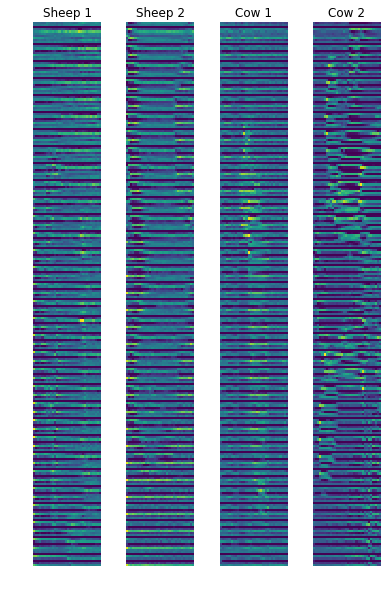

In [0]:
# Show encoded representations
encoder = Model(input_img, encoded)
encoded_imgs = encoder.predict(xtrain)
pl.figure(1, figsize=(6.4, 10))

s = int(len(xtrain[0])/8)

pl.subplot(1, 4, 1)
pl.imshow(encoded_imgs[3].reshape(s, s * 8).T)
pl.axis('off')
pl.title('Sheep 1')

pl.subplot(1, 4, 2)
pl.imshow(encoded_imgs[1].reshape(s, s * 8).T)
pl.axis('off')
pl.title('Sheep 2')

pl.subplot(1, 4, 3)
pl.imshow(encoded_imgs[-1].reshape(s, s * 8).T)
pl.axis('off')
pl.title('Cow 1')

pl.subplot(1, 4, 4)
pl.imshow(encoded_imgs[-2].reshape(s, s * 8).T)
pl.axis('off')
pl.title('Cow 2')

### AE3

In [0]:
# AE3
# size code --> /16

from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K

input_img = Input(shape=(len(xtrain[0]),len(xtrain[0,0]),len(xtrain[0,0,0]))) 
# 196608 dimensions if 256
# 49152 if 128

net = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
net = MaxPooling2D((2, 2), padding='same')(net)
net = Conv2D(8, (3, 3), activation='relu', padding='same')(net)
net = MaxPooling2D((2, 2), padding='same')(net)
net = Conv2D(8, (3, 3), activation='relu', padding='same')(net)
net = MaxPooling2D((2, 2), padding='same')(net)
net = Conv2D(8, (3, 3), activation='relu', padding='same')(net)
encoded = MaxPooling2D((2, 2), padding='same')(net)

# "code" layer: at this point the representation is 
  # (32, 32, 8) --> 8192 dimensions if 256
  # (16, 16, 8) --> 2018 if 128

net = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
net = UpSampling2D((2, 2))(net)
net = Conv2D(8, (3, 3), activation='relu', padding='same')(net)
net = UpSampling2D((2, 2))(net)
net = Conv2D(8, (3, 3), activation='relu', padding='same')(net)
net = UpSampling2D((2, 2))(net)
net = Conv2D(16, (3, 3), activation='relu', padding='same')(net)
net = UpSampling2D((2, 2))(net)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(net)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')
print(autoencoder.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_33 (InputLayer)        (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 256, 256, 16)      448       
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 128, 128, 8)       1160      
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 64, 64, 8)         0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 64, 64, 8)         584       
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 32, 32, 8)         0         
__________

Train on 153 samples, validate on 150 samples
Epoch 1/100
153/153 [==============================] - 1s 5ms/step - loss: 0.0120 - val_loss: 0.0121
Epoch 2/100
153/153 [==============================] - 1s 4ms/step - loss: 0.0120 - val_loss: 0.0119
Epoch 3/100
153/153 [==============================] - 1s 4ms/step - loss: 0.0120 - val_loss: 0.0119
Epoch 4/100
153/153 [==============================] - 1s 5ms/step - loss: 0.0120 - val_loss: 0.0119
Epoch 5/100
153/153 [==============================] - 1s 4ms/step - loss: 0.0120 - val_loss: 0.0119
Epoch 6/100
153/153 [==============================] - 1s 4ms/step - loss: 0.0120 - val_loss: 0.0119
Epoch 7/100
153/153 [==============================] - 1s 4ms/step - loss: 0.0121 - val_loss: 0.0120
Epoch 8/100
153/153 [==============================] - 1s 4ms/step - loss: 0.0121 - val_loss: 0.0121
Epoch 9/100
153/153 [==============================] - 1s 4ms/step - loss: 0.0120 - val_loss: 0.0119
Epoch 10/100
153/153 [=======================

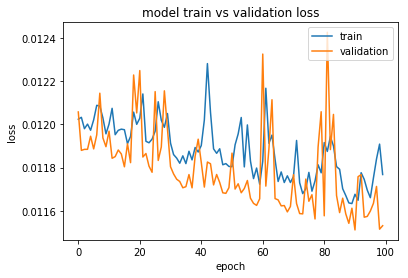

In [0]:
history = autoencoder.fit(xtrain, xtrain,
                epochs=100,
                batch_size=16,
                shuffle=True,
                validation_data=(xval, xval))

# Plot the loss --> (binary cross-entropy) MSE
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

Relu, Linear, And Sigmoid --> all val_loss = 0.017 after 300 epochs (with adam)

SGD (with sigmoid) --> val_loss = 0.045 after 300 epochs (and reconstructed images very bad) => keep adam 



0.011599977


Text(0.5, 1.0, 'Cow 2')

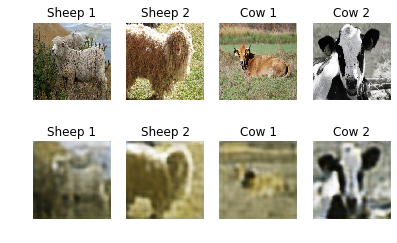

In [0]:
decoded_imgs = autoencoder.predict(xtrain)
decoded_rs = decoded_imgs.reshape(len(xtrain), len(xtrain[0])*len(xtrain[0,0])*len(xtrain[0,0,0]))

print(mean_squared_error(xrs,decoded_rs))

# plot 2 "good" images of each class
pl.figure(1, figsize=(6.4, 4))

pl.subplot(2, 4, 1)
pl.imshow(xtrain[3])
pl.axis('off')
pl.title('Sheep 1')

pl.subplot(2, 4, 2)
pl.imshow(xtrain[1])
pl.axis('off')
pl.title('Sheep 2')

pl.subplot(2, 4, 3)
pl.imshow(xtrain[-1])
pl.axis('off')
pl.title('Cow 1')

pl.subplot(2, 4, 4)
pl.imshow(xtrain[-2])
pl.axis('off')
pl.title('Cow 2')

pl.subplot(2, 4, 5)
pl.imshow(decoded_imgs[3])
pl.axis('off')
pl.title('Sheep 1')

pl.subplot(2, 4, 6)
pl.imshow(decoded_imgs[1])
pl.axis('off')
pl.title('Sheep 2')

pl.subplot(2, 4, 7)
pl.imshow(decoded_imgs[-1])
pl.axis('off')
pl.title('Cow 1')

pl.subplot(2, 4, 8)
pl.imshow(decoded_imgs[-2])
pl.axis('off')
pl.title('Cow 2')

reconstruction worse than with AE1 / AE2 (and AE2 worse than AE1)

Manu: for them worse too, but prof said should be better

--> why? smaller = more bottleneck = more info lost ??



Text(0.5, 1.0, 'Cow 2')

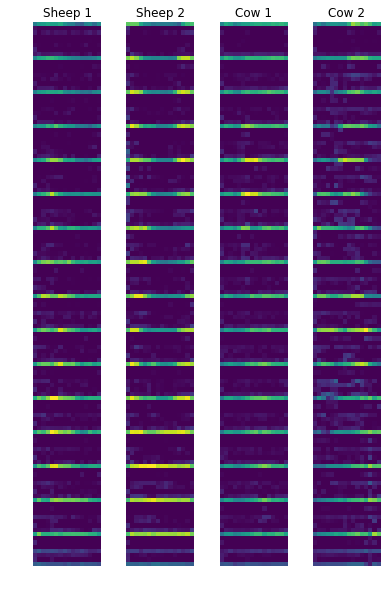

In [0]:
# Show encoded representations
encoder = Model(input_img, encoded)
encoded_imgs = encoder.predict(xtrain)
pl.figure(1, figsize=(6.4, 10))

s = int(len(xtrain[0])/16)

pl.subplot(1, 4, 1)
pl.imshow(encoded_imgs[3].reshape(s, s * 8).T)
pl.axis('off')
pl.title('Sheep 1')

pl.subplot(1, 4, 2)
pl.imshow(encoded_imgs[1].reshape(s, s * 8).T)
pl.axis('off')
pl.title('Sheep 2')

pl.subplot(1, 4, 3)
pl.imshow(encoded_imgs[-1].reshape(s, s * 8).T)
pl.axis('off')
pl.title('Cow 1')

pl.subplot(1, 4, 4)
pl.imshow(encoded_imgs[-2].reshape(s, s * 8).T)
pl.axis('off')
pl.title('Cow 2')

### To do

TO DO if we want: greedy layer-wise training (see ANN exercise session 3)

1) Train 1st layer as AE with 1 hidden layer

2) Predict encoder part with training data 
          
          features = encoder.predict(xtrain)
          
3) Train 2nd layer as AE with 1 hidden layer, and use features as input

4) Predict encoder part

5) Train 3rd layer as AE with 1 hidden layer, and use features obtained in step 4

etc.


Manu: should achieve very good accuracy (for classification (?))

# Classification

In [0]:
# AE1
# size code --> /4

input_img = Input(shape=(len(xtrain[0]),len(xtrain[0,0]),len(xtrain[0,0,0]))) 
# 196608 dimensions if 256
# 49152 if 128

net = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
net = MaxPooling2D((2, 2), padding='same')(net)
net = Conv2D(8, (3, 3), activation='relu', padding='same')(net)
net = MaxPooling2D((2, 2), padding='same')(net)
net = Conv2D(8, (3, 3), activation='relu', padding='same')(net)
encoded = MaxPooling2D((2, 2), padding='same')(net)

# "code" layer: at this point the representation is 
  # (32, 32, 8) --> 8192 dimensions if 256
  # (16, 16, 8) --> 2018 if 128

net = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
net = UpSampling2D((2, 2))(net)
net = Conv2D(8, (3, 3), activation='relu', padding='same')(net)
net = UpSampling2D((2, 2))(net)
net = Conv2D(16, (3, 3), activation='relu', padding='same')(net)
net = UpSampling2D((2, 2))(net)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(net)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

history = autoencoder.fit(xtrain, xtrain,
                epochs=100,
                batch_size=16,
                shuffle=True,
                validation_data=(xval, xval),
                verbose=0)



# 
encoder = Model(input_img, encoded)
encoded_imgs = encoder.predict(xtrain)
encoder.save(path+'AE1model.h5')
encoder.save_weights(path+'AE1weights.h5')


In [0]:
encoder_frozen = load_model(path+'AE1model.h5')
for layer in encoder_frozen.layers:
  layer.trainable = False
print(encoder_frozen.summary())


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 256, 256, 16)      448       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 128, 128, 8)       1160      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 64, 64, 8)         0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 64, 64, 8)         584       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 32, 32, 8)         0         
Total para

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [0]:


#classifier = Model(encoder_frozen.input, classOut)

#net = Flatten()(encoder_frozen.output) # (16, 16, 8) --> 2048     (32, 32, 8) --> 8192
#N = int(len(xtrain[0])/8 * len(xtrain[0,0])/8 * 8)
#net = Dense(N, activation='relu')(net)
#classOut = Dense(2, activation='softmax')(net) #  simple logistic regression

In [0]:
net = Flatten()(encoder_frozen.output)
classOut = Dense(2, activation='sigmoid')(net) #  simple logistic regression
  # not softmax because we could have a multi-label image, with both sheeps and cows
  # softmax --> only one label
classifier = Model(encoder_frozen.input, classOut)
print(classifier.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 256, 256, 16)      448       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 128, 128, 8)       1160      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 64, 64, 8)         0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 64, 64, 8)         584       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 32, 32, 8)         0         
__________

In [0]:
#autoencoder = Model(input_img, classOut)
classifier.compile(optimizer='adam', loss='binary_crossentropy')

history = classifier.fit(xtrain, ytrain,
                epochs=50,
                batch_size=16,
                shuffle=True,
                validation_data=(xval, yval))
# Plot the loss --> (binary cross-entropy) MSE
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

Train on 153 samples, validate on 150 samples
Epoch 1/50
153/153 [==============================] - 1s 5ms/step - loss: 0.8375 - val_loss: 0.7180
Epoch 2/50
153/153 [==============================] - 0s 2ms/step - loss: 0.5853 - val_loss: 0.8445
Epoch 3/50
153/153 [==============================] - 0s 2ms/step - loss: 0.5541 - val_loss: 0.7446
Epoch 4/50
153/153 [==============================] - 0s 2ms/step - loss: 0.5318 - val_loss: 0.7784
Epoch 5/50
153/153 [==============================] - 0s 2ms/step - loss: 0.6268 - val_loss: 0.7455
Epoch 6/50
153/153 [==============================] - 0s 2ms/step - loss: 0.4792 - val_loss: 0.7422
Epoch 7/50
153/153 [==============================] - 0s 2ms/step - loss: 0.4515 - val_loss: 0.7451
Epoch 8/50
153/153 [==============================] - 0s 2ms/step - loss: 0.4518 - val_loss: 0.7385
Epoch 9/50
153/153 [==============================] - 0s 2ms/step - loss: 0.4375 - val_loss: 0.7563
Epoch 10/50
153/153 [==============================] -

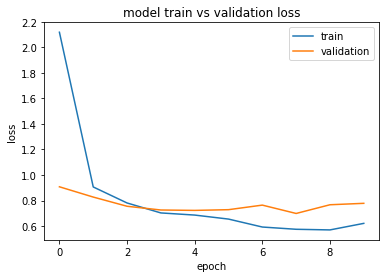